<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignment 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [10]:
##### Your Code Here #####
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import boston_housing
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

In [33]:
print(f"The shape of the x train is:  {x_train.shape}")
print(f"The shape of the y_train is: {y_train.shape}")
print(f"The shape of the x_test is : {x_test.shape}")
print(f"The shape of the y_test is: {y_test.shape}")
# Will not need to flatten anything becuase it is only a two dimensional array

The shape of the x train is:  (404, 13)
The shape of the y_train is: (404,)
The shape of the x_test is : (102, 13)
The shape of the y_test is: (102,)


In [34]:
# looking at the shape of one row of the data
# and what is in it
x_train[:1]

array([[  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
         91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
         18.72   ]])

In [35]:
type(x_train)

numpy.ndarray

In [36]:
# function that will do the normalization
def normalization(num_array):
     arr =  num_array/np.amax(num_array, axis=0)
     return arr

In [37]:
# Doing the normalization
x_train_norm = normalization(x_train)
x_test_norm = normalization(x_test)

In [38]:
# Looking at the difference between the non normalized and the 
# normalized version
x_train[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [39]:
x_test_norm[0]

array([0.72205254, 0.        , 0.65248738, 0.        , 0.77956372,
       0.73280182, 1.        , 0.15129675, 1.        , 0.93670886,
       0.95283019, 0.06865709, 0.90809628])

In [40]:
# Instanciating the model
model = Sequential()

In [41]:
# getting the callback function that I want to use
the_callback = EarlyStopping(patience=1, monitor="loss")

In [42]:
# Builing the model
# adding layers to the model
model.add(Dense(64, input_shape=(13,), activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dense(128, activation="relu"))
#model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="linear"))

# Doing the compiliation of the model
model.compile(optimizer="adam", loss="mse", metrics=['mse', "mae", ] )

In [43]:
# looking at the summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 9,345
Trainable params: 9,345
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Doing the fitting of the model
model.fit(x=x_train_norm, y=y_train, epochs=50,  validation_data=(x_test_norm, y_test),
callbacks=[the_callback]
) 

Train on 404 samples, validate on 102 samples
Epoch 1/50
404/404 [==============================] - 0s 99us/sample - loss: 39.2661 - mse: 39.2661 - mae: 4.3589 - val_loss: 44.1775 - val_mse: 44.1775 - val_mae: 4.6121
Epoch 2/50
404/404 [==============================] - 0s 87us/sample - loss: 38.3772 - mse: 38.3772 - mae: 4.2263 - val_loss: 42.6666 - val_mse: 42.6666 - val_mae: 4.5657
Epoch 3/50
404/404 [==============================] - 0s 99us/sample - loss: 37.5357 - mse: 37.5357 - mae: 4.1851 - val_loss: 42.5357 - val_mse: 42.5357 - val_mae: 4.5502
Epoch 4/50
404/404 [==============================] - 0s 84us/sample - loss: 36.8657 - mse: 36.8657 - mae: 4.3162 - val_loss: 41.3122 - val_mse: 41.3122 - val_mae: 4.5070
Epoch 5/50
404/404 [==============================] - 0s 79us/sample - loss: 36.4913 - mse: 36.4913 - mae: 4.0538 - val_loss: 41.4079 - val_mse: 41.4079 - val_mae: 4.5069
Epoch 6/50
404/404 [==============================] - 0s 92us/sample - loss: 34.8087 - mse: 34.8087

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- The number of nodes in your output layer should equal the number of classes you want to predict for Fashion-MNIST.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [2]:
# Doing the Fashion-Minst
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Flatten
# Doing an import to show an image
import matplotlib.pyplot as plt

In [3]:
# Loading the data set 
(x_train, y_train), (x_test, y_test) =  fashion_mnist.load_data()

In [4]:
# Looking at the shapes of the data
print(f"The shape of the x_train is:  {x_train.shape}")
print(f"The shape of the y_train is: {y_train.shape}")
print(f"The shape of the x_test is: {x_test.shape}")
print(f"The shape of the y_test is: {y_test.shape}")

The shape of the x_train is:  (60000, 28, 28)
The shape of the y_train is: (60000,)
The shape of the x_test is: (10000, 28, 28)
The shape of the y_test is: (10000,)


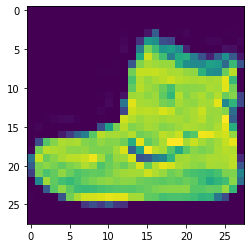

In [5]:
# Looking at the shoe, this is just one of the images
plt.imshow(x_train[0])

In [6]:
# Looking at one the arrays
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [7]:
# Function used to normalize the data
def normalize_img(num_array):
    arry = num_array/255
    return arry

In [8]:
x_train_norm = normalize_img(x_train)
x_test_norm = normalize_img(x_test)
print(x_train_norm.shape, x_test_norm.shape)

(60000, 28, 28) (10000, 28, 28)


In [11]:
model = Sequential()

In [12]:
# Creating a function that will create the model
def create_model(input_shape = (28,28), flatten=False ):
    model = Sequential()
   
    
    
    # if the flatten flage is set to true will flatten the array
    if flatten == True:
        model.add(Flatten(input_shape=input_shape))
        input_shape = None
    if input_shape != None:
        model.add(Dense(128, input_shape=input_shape,  activation="relu"))
    else:
        None
        model.add(Dense(128, activation="relu"))
    #model.add(Dense(64, activation="relu"))
    model.add(Dense(10, activation="softmax"))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model
 

In [13]:
import tensorflow as tf


In [14]:
the_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=2)

In [15]:
# Creating the model
model = create_model(flatten=True)

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [17]:
%load_ext tensorboard

import os
import datetime


In [18]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [19]:
# Doing some of the training on the model
results = model.fit(x=x_train_norm, y=y_train, callbacks=[the_callback, tensorboard_callback], validation_data=(x_test_norm, y_test), epochs=20 )

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 74us/sample - loss: 0.5055 - accuracy: 0.8218 - val_loss: 0.4410 - val_accuracy: 0.8443
Epoch 2/20
60000/60000 [==============================] - 4s 59us/sample - loss: 0.3813 - accuracy: 0.8618 - val_loss: 0.3847 - val_accuracy: 0.8627
Epoch 3/20
60000/60000 [==============================] - 4s 60us/sample - loss: 0.3401 - accuracy: 0.8751 - val_loss: 0.3759 - val_accuracy: 0.8676
Epoch 4/20
60000/60000 [==============================] - 4s 62us/sample - loss: 0.3154 - accuracy: 0.8840 - val_loss: 0.3866 - val_accuracy: 0.8619
Epoch 5/20
60000/60000 [==============================] - 4s 62us/sample - loss: 0.2979 - accuracy: 0.8893 - val_loss: 0.3664 - val_accuracy: 0.8690
Epoch 6/20
60000/60000 [==============================] - 4s 59us/sample - loss: 0.2811 - accuracy: 0.8960 - val_loss: 0.3606 - val_accuracy: 0.8687
Epoch 7/20
60000/60000 [==============================] 

In [21]:
# showing he tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 7516), started 0:01:50 ago. (Use '!kill 7516' to kill it.)

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.